In [424]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

Load data

In [ ]:
# Columns for abalone dataframe
columns = [
    "Sex", "Length", "Diameter", "Height", "WholeWeight",
    "ShuckedWeight", "VisceraWeight", "ShellWeight", "Rings"]

# Load Abalone dataframe from csv file
df = pd.read_csv('./abalone/abalone.data', header=None, names=columns)

# Look at first rows of abalone dataframe
df.head()

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In order to train model we need convert "Sex" column from the categorial variable into numerical values

Preprocess the data

In [426]:
# Use LabelEncoder for transformin "Sex" column to numerical values
label_encoder = LabelEncoder()

# Apply transorm and replace default values
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Check it out our result
df.head()

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [427]:
# Get dataframe info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   int64  
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


We have canverted our "Sex" column from the categorial variable into numerical values

There is no NaN values and categorial variable and we can work on analize data

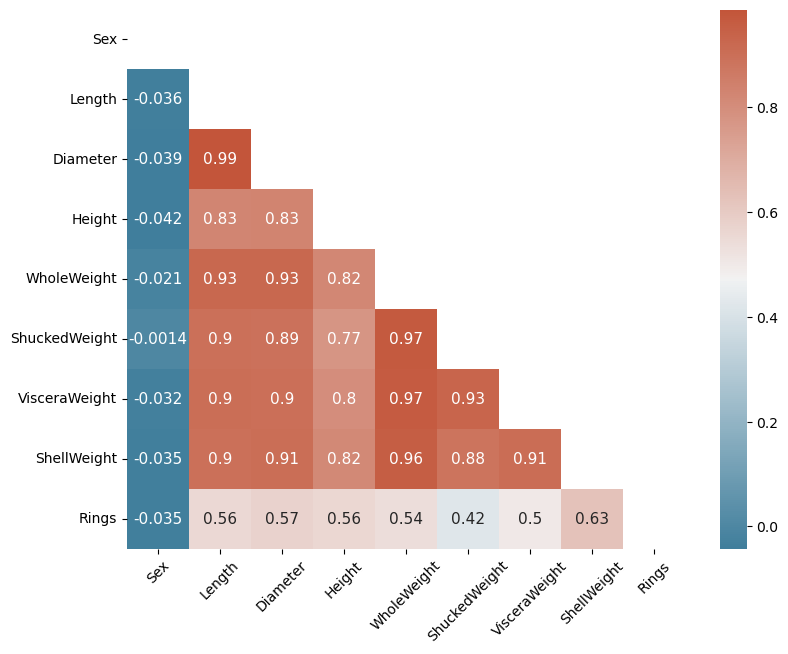

In [428]:
# Build correlation matrix
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(9, 7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.xticks(rotation=45)
plt.show()

In the plot above we can see very huge correlation between features. Let's try to deacress it.

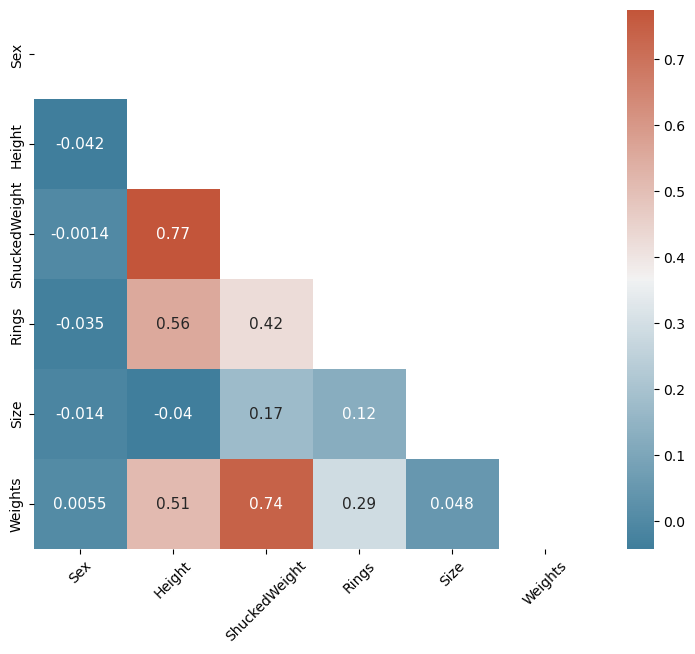

In [ ]:
# Create a new features 
df['Size'] = df['Diameter'] / (df['Length'] + df['Height'])
df['Weights'] = df['WholeWeight'] *  df['VisceraWeight'] * df['ShellWeight'] * df['ShuckedWeight']

# Drop the most correlation columns
df = df.drop(columns=['Diameter', 'Length', 'WholeWeight', 'VisceraWeight', 'ShellWeight'])

# Build correlation matrix
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(9, 7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.xticks(rotation=45)
plt.show()

I have tried to resolve issues with the correlation matrix, but a lot of columns correlate with each other and I have to drop them. For instance, 'Height' and  'Shuckedwight' features have very high values as well, we leave it because dataframe has already not enough data. Two new features 'Size' and 'Weights' help me generate more data for the training model.

Visualize, visualize, visualize ...

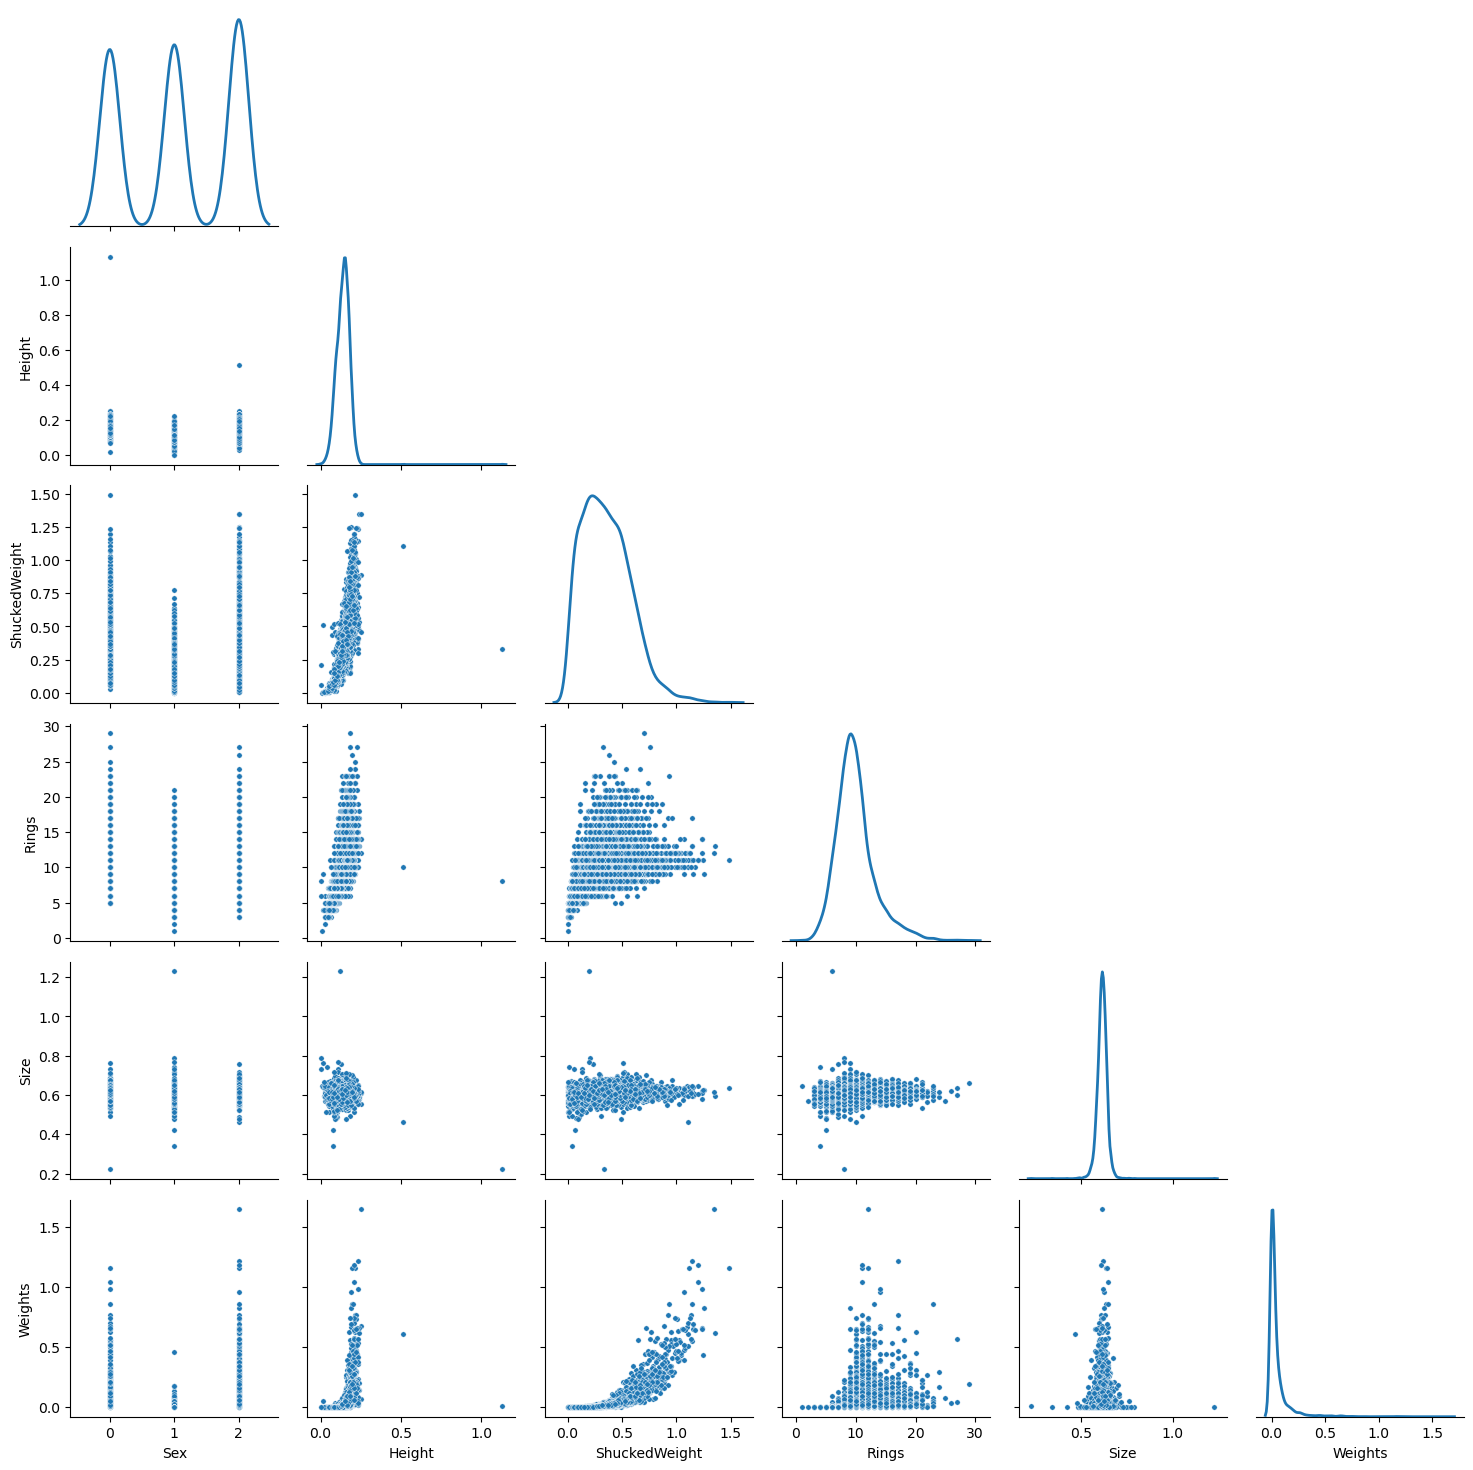

In [ ]:
# Visualize pair grid for our model
pairGrid = sns.PairGrid(df, corner=True, diag_sharey=False)

# Lower part of grid
pairGrid.map_lower(sns.scatterplot, s=15)

# Diagonal 
pairGrid.map_diag(sns.kdeplot, lw=2)

In the Grid above we can observe some minimal dependencies of feature and outlayers, but in general it won't be affected to result. Let see and if it happen return back to it.

In [431]:
# Split the data into features (X) and target variable (y)
X = df.drop("Rings", axis=1)
y = df["Rings"]


Scale and split the data

In [432]:
# Scale the data using StandardScaler
scaler = StandardScaler()

# Scale X 
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


Apply scaler to data frame and split out data in proportion 0.8 for train and 0.2 for test. 

Train a kNN regression model

In [433]:
# Create kNN Regressor model with neigbors = 5
knn = KNeighborsRegressor(n_neighbors=5) 

# Cross validate model
cv_sc = cross_val_score(knn, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.38243836 0.41375619 0.39379414 0.39526812]


Cross Validation has difference a little bit. Seems data frame is not well balanced, but it's not critical

In [434]:
# Train model
knn.fit(X_train, y_train)

print(f'Train Score: {knn.score(X_train, y_train)}')
print(f'Test Score: {knn.score(X_test, y_test)}')

Train Score: 0.5978608778663127
Test Score: 0.39192092307171733


Test score has different value depending on train score but it' s not critical

Predict result and evaluate model

In [435]:
# Predict result
y_pred = knn.predict(X_test)

# Calculate MSE error and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 6.582583732057417
R-squared (R²): 0.39192092307171733


The errors are quite high on MSE, but R2 are better, a possible reason is the large number of classes and outliers, which greatly increase the indicator

Model improvement

In [ ]:
# Create Grid Search to calculate the best count neighbors for kNN model
param_grid = {'n_neighbors': range(1, 20)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=4, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Best k: {grid_search.best_params_['n_neighbors']}")
print(f"Best R-squared (R²): {grid_search.best_score_}")

Best k: 13
Best R-squared (R²): 0.44121190101104535


It's look like much better. Grid search CV points out that 13 count neighbors is best for our kNN model.

Let's train new kNN model with 13 neighbors

In [437]:
# New kNN model with neighbors eaual 13 
knn_imp = KNeighborsRegressor(n_neighbors=13) 

# Train model
knn_imp.fit(X_train, y_train)

print(f'Train Score: {knn_imp.score(X_train, y_train)}')
print(f'Test Score: {knn_imp.score(X_test, y_test)}')

# Predict result
y_pred_imp = knn_imp.predict(X_test)

# Calculate MSE error and R2 score
mse = mean_squared_error(y_test, y_pred_imp)
r2 = r2_score(y_test, y_pred_imp)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Train Score: 0.5337791274427401
Test Score: 0.43094513467852846
Mean Squared Error (MSE): 6.160138444551401
R-squared (R²): 0.43094513467852846


Train score left the same like with 5 neighbors, and test scoring increases. MSE and R2 parameters become much better.

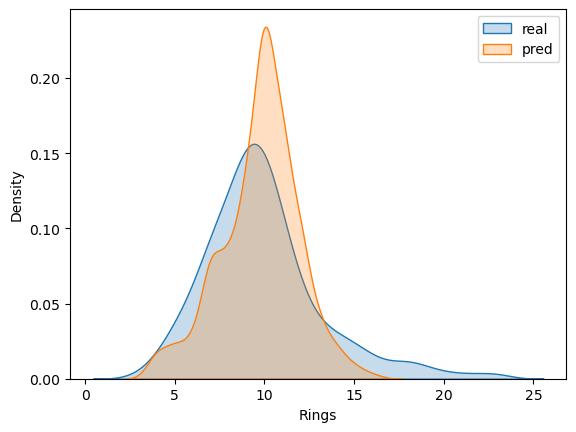

In [438]:
# Visualize our result
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(y_pred_imp, 0), fill=True, label='pred')
plt.legend()

The graph shows that the model does not affect extreme values ​​and there is a tendency for erroneous class assignment around 10.

Conclusion: The result is not satisfy. Trainging and test score are not high. Metrics are not very good, MSE is quite high, P2 < 0.5. I could archive best result with 13 number neighbors than with 5, but result was not quite changed. Also I've tried use weights='distance' and  p=1 parameters for kNN model, but the result was the same. Perhaps the reason for the bed training model was the high correlation of data and not enough features.

Classification model

In [439]:
# Make sure that data frame is ok and 'Sex' target has numberical values
df.head()

,Sex,Height,ShuckedWeight,Rings,Size,Weights
0,2,0.095,0.2245,15,0.663636,0.001748
1,2,0.090,0.0995,7,0.602273,0.000076
2,0,0.135,0.2565,9,0.631579,0.005160
3,2,0.125,0.2155,10,0.646018,0.001965
4,1,0.080,0.0895,7,0.621951,0.000040


In [440]:
# Split the data into features (X) and target variable (y)
X_class = df.drop("Sex", axis=1)
y_class = df["Sex"]

Scale and split the data

In [441]:
# Scale the data using StandardScaler
scaler_class = StandardScaler()

# Scale X 
X_scaled = scaler_class.fit_transform(X)

# Split data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42, shuffle=True)


In [442]:
# Train a kNN classification model with 13 neighbors (we figure out that 13 is the best number)
knn_class = KNeighborsClassifier(n_neighbors=13)  # Choose the number of neighbors
knn_class.fit(X_train_class, y_train_class)

# Make predictions on the test set
y_pred_class = knn_class.predict(X_test_class)

Evaluate model 

In [443]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test_class, y_pred_class))
print('Confusion Matrix:')
print(confusion_matrix(y_test_class, y_pred_class))

Accuracy: 0.53
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.37      0.38       262
           1       0.70      0.80      0.75       267
           2       0.46      0.43      0.45       307

    accuracy                           0.53       836
   macro avg       0.52      0.53      0.53       836
weighted avg       0.52      0.53      0.52       836

Confusion Matrix:
[[ 97  37 128]
 [ 25 213  29]
 [120  54 133]]


Conclusion: The model is able to correctly classify approximately 40% of the samples in Male and Female class. This means that out of all the samples that are actually Male, or Female, the model is able to correctly identify about 40% of them. For Infant value equal around 70%. Accuracy value equal 0.53 and well-balanced dataframe are not good and not bad result, but low precision and recall for Male and Female point us to focus on improving the dataset, features, or model algorithm. 